In [1]:
import os
from google.colab import drive
drive.mount("/content/drive",force_remount=False)


Mounted at /content/drive


In [2]:
os.chdir("/content/drive/My Drive/perception projects/object tracking")
!ls

images					       YOLO_simple.ipynb
mask_rcnn				       yolo_Starter.ipynb
mask_rcnn_inception_v2_coco_2018_01_28.tar.gz  yolov3
Mask_RCNN.ipynb				       Yolov4
movie.mp4


In [3]:
import cv2
import argparse
import numpy as np
import os.path
import sys
import random
import matplotlib.pyplot as plt

In [ ]:
# !wget http://download.tensorflow.org/models/object_detection/mask_rcnn_inception_v2_coco_2018_01_28.tar.gz
# !tar zxvf mask_rcnn_inception_v2_coco_2018_01_28.tar.gz
# #if downloaded manually move to "mask_rcnn" folder!

In [4]:
#initialize parameters
confThreshold = 0.5           #confidence threshold
maskThreshold = 0.3           #Mask threshold

#set up argument parser....helps run directly from terminal
# parser = argparse.ArgumentParser(description='Use this script to run Mask-RCNN object detection and segmentation')
# parser.add_argument('--image', help='Path to image file')
# parser.add_argument('--video', help='Path to video file.')
# parser.add_argument("--device", default="cpu", help="Device to inference on")
# args = parser.parse_args()

In [5]:
# Draw the predicted bounding box, colorize and show the mask on the image
def DrawBox(frame, classId,conf, left, top, right, bottom, classMask):
  #Draw a bounding box
  box_color = (255,178,50)
  cv2.rectangle(frame, (left,top), (right,bottom), box_color, 3)

  #print label of class
  label = "%.2f" % conf
  if classes:
    assert(classId < len(classes))
    label = "%s:%s" % (classes[classId],label)


  
  #COLORS IS NOT IN THE FUNCTION
  color = colors[classId%len(colors)]       
  #comment the above line and uncomment the two lines below to generate different instance colors
  # colorIndex = random.randint(0, len(colors)-1)
  # color = colors[colorIndex]

  #Resize the mask, threshold ,color and apply it on the image
  classMask = cv2.resize(classMask , (right - left + 1, bottom - top + 1))
  mask = (classMask > maskThreshold)  #threshold
  roi = frame[top:bottom+1, left:right+1][mask]

  frame[top:bottom+1, left:right+1][mask] = ([0.3*color[0], 0.3*color[1], 0.3*color[2]] + 0.7 * roi).astype(np.uint8)  #colorize map
  
  #Draw the contours on the image
  mask = mask.astype(np.uint8)
  contours , hierarchy = cv2.findContours(mask,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
  cv2.drawContours(frame[top:bottom+1, left:right+1], contours, -1, color, -3, cv2.LINE_8, hierarchy, 100) 

  # Display the label at the top of the bounding box
  labelSize, baseLine = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
  top = max(top, labelSize[1])
  cv2.rectangle(frame, (left, top - round(1.5*labelSize[1])), (left + round(1.5*labelSize[0]), top + baseLine), (255, 255, 255), cv2.FILLED)
  cv2.putText(frame, label, (left, top), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0,0,0), 1)

  return frame,label

In [6]:
# For each frame, extract the bounding box and mask for each detected object
def postprocess(frame,boxes,masks):
  # Output size of masks is NxCxHxW where
    # N - number of detected boxes
    # C - number of classes (excluding background)
    # HxW - segmentation shape
    numClasses = masks.shape[1]
    numDetections = masks.shape[0]

    detected_labels = []

    #FRAME SHAPE IS NEVER PASSED INTO FUNCTION...GLOBAL VARIABLE
    frameH = frame.shape[0]
    frameW = frame.shape[1]

    for i in range(numDetections):
      box = boxes[0,0,i]
      mask = masks[i]
      score = box[2]
      if score > confThreshold:
        classId = int(box[1])

        #extract the bounding box
        left = int(frameW * box[3])
        top = int(frameH * box[4])
        right = int(frameW *box[5])
        bottom = int(frameH * box[6])

        #Values cant be negative
        left = max(0, min(left, frameW - 1))
        top = max(0, min(top, frameH - 1))
        right = max(0, min(right, frameW - 1))
        bottom = max(0, min(bottom, frameH - 1))

        #extract the mask for the object
        classMask = mask[classId]

        #Draw bounding box, colorize and show the mask on the image
        frame, label= DrawBox(frame, classId, score, left, top, right, bottom, classMask)
        detected_labels.append(label)
    return frame, detected_labels

In [7]:
#load names of classes
classesFile = "mask_rcnn/mscoco_labels.names"
classes = None
with open(classesFile,'rt') as f:
  classes = f.read().rstrip('\n').split('\n')

#Give the textGraph and weight files for the model
textGraph = "mask_rcnn/mask_rcnn_inception_v2_coco_2018_01_28.pbtxt"
modelWeights = "mask_rcnn/mask_rcnn_inception_v2_coco_2018_01_28/frozen_inference_graph.pb"

#load the network
net = cv2.dnn.readNetFromTensorflow(modelWeights, textGraph)
net.setPreferableBackend(cv2.dnn.DNN_TARGET_CPU)

# For using GPU DEVICES
# net.setPreferableBackend(cv.dnn.DNN_BACKEND_CUDA)
# net.setPreferableTarget(cv.dnn.DNN_TARGET_CUDA)


#load color list from text file
colorsFile = "mask_rcnn/colors.txt";
with open(colorsFile, 'rt') as f:
    colorsStr = f.read().rstrip('\n').split('\n')
colors = [] #[0,0,0]
for i in range(len(colorsStr)):
    rgb = colorsStr[i].split(' ')    
    color = np.array([float(rgb[0]), float(rgb[1]), float(rgb[2])])
    colors.append(color)


In [8]:
def inference(frame):
  # Create a 4D blob from a frame.  convert image into 4d blob as DNN input
  blob = cv2.dnn.blobFromImage(frame,swapRB=True, crop=False)
  
  #set the input to the network
  net.setInput(blob)

  #run the forward pass to get output from the output layers
  boxes, masks = net.forward(['detection_out_final', 'detection_masks'])

  frame, found_labels = postprocess(frame,boxes,masks)
  return frame, found_labels      #remove "found_labels" to run with moviepyeditor

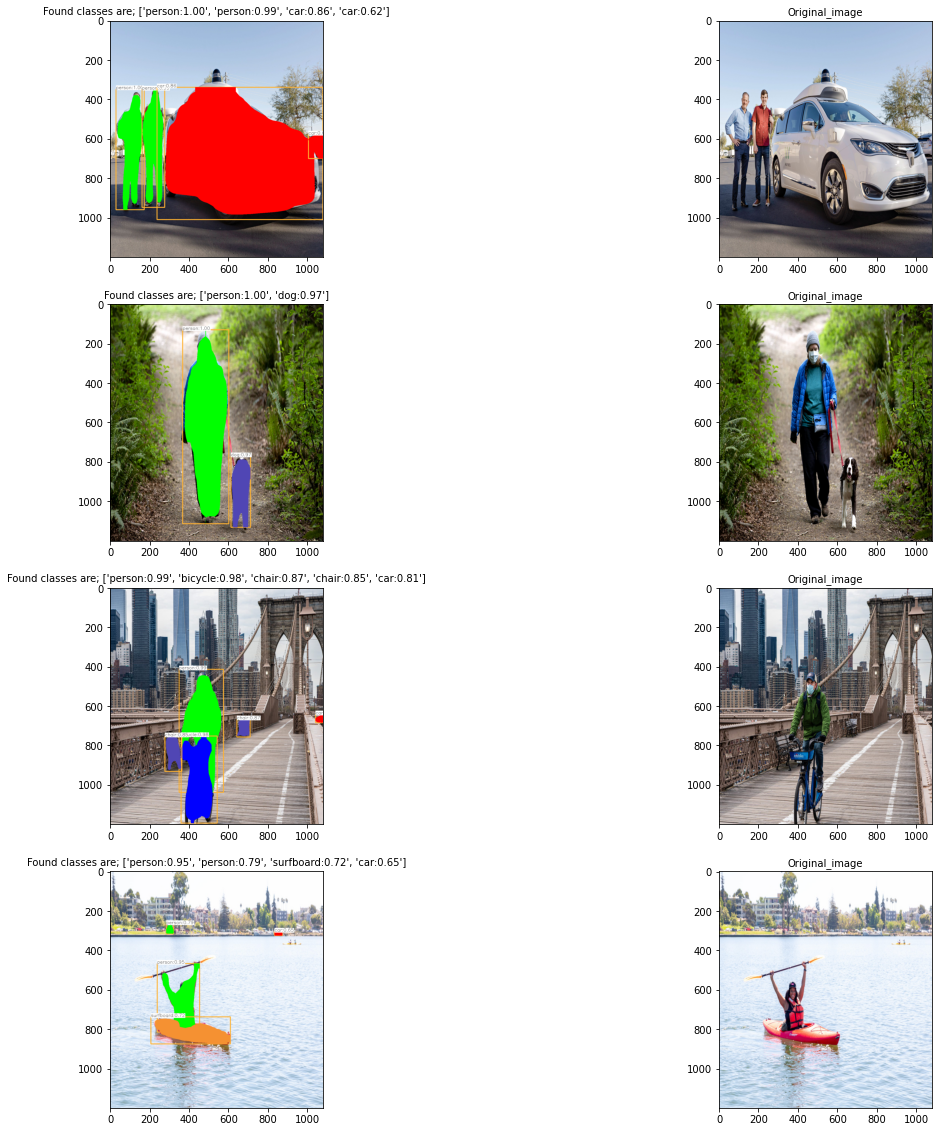

In [12]:
# !pwd
# img = plt.imread("images/man_bike.jpg")
# img = cv2.resize(img,(1080,1200))
# oi,_ = inference(img)
# plt.figure(figsize=(15,15))
# plt.imshow(oi)
# plt.show()
# plt.imsave("mask_rcnn/outputs/output.jpg",oi)

# //////////////////////
import glob
imgs = sorted(glob.glob("images/*.jpg"))
nm = len(imgs)
f, axs = plt.subplots(nm,nm//2,figsize= (20,20))    #2 columns for every picture
for i in range(len(imgs)):
  img = plt.imread(imgs[i])
  img = cv2.resize(img,(1080,1200))
  axs[i,1].imshow(img)
  axs[i,1].set_title("Original_image", fontsize=10)

  oi, f_labels = inference(img) #run inference
  axs[i,0].imshow(oi)
  #check if any labels were found
  if len(f_labels) == 0:
    axs[i,0].set_title('No classes were found in this image', fontsize=10)
  else:
    " - ".join(f_labels)
    f_labels = "Found classes are; " + str(f_labels)
    axs[i,0].set_title(str(f_labels), fontsize=10)
  

In [62]:
from moviepy.editor import VideoFileClip
# !pwd
video_file = "images/day_drive_3mins.mp4"
clip = VideoFileClip(video_file).subclip(100,105)
white_clip = clip.fl_image(inference)
%time white_clip.write_videofile("mask_rcnn/outputs/movie.mp4",audio=False)

[MoviePy] >>>> Building video mask_rcnn/outputs/movie.mp4
[MoviePy] Writing video mask_rcnn/outputs/movie.mp4


100%|██████████| 150/150 [16:59<00:00,  6.80s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: mask_rcnn/outputs/movie.mp4 

CPU times: user 32min 4s, sys: 1.93 s, total: 32min 6s
Wall time: 17min
